# SBI experiments: an introduction

In this notebook, we will analyse the performance of Simulation-based inference algorithms in estimating the posterior distribution of the parameters defined in the Two Moons model.

## The model

We will choose a model where both parameters and data are sampled from a multivariate normal distribution.

The parameters $\bm{\theta} \in \mathbb{R}^n$ are sampled from

$$ \bm{\theta} \sim \mathcal{N}(\mu=\bm{0}_n, \Sigma=0.01 \bm{I}_n),$$

where $\bm{I}_n$ is the n x n identity matrix. The data $\bm{x} \in \mathbb{R}^n$ are generated as follows:

$$ \bm{x} \sim \mathcal{N}(\mu=\bm{\theta}, \Sigma=0.01 \bm{I}_n) $$


In [1]:
import sys

sys.path.append("..")

import torch
from torch import Tensor
import arviz as az
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

%config InlineBackend.figure_format = 'retina'

/Users/bernardoveronese/miniconda3/envs/sbibench/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


We implement the model as a Pyro model in the `gaussian_linear_model` function below. Pyro is a probabilistic programming laguange built on top of Pytorch. Pytorch is a a machine learning library. In a nutshell, multi-dimensional arrays in Pytorch are a `torch.Tensor`, and have very similar functionalities to Numpy's `ndarray` class, while also having support for running on GPUs.

We are using Pyro because we are going to benefit from its built-in implementation of some MCMC samplers.

In [2]:
ndim = 10
seed = 1998
# pyro.set_rng_seed(seed)

# def prior_dist():
#     loc = pyro.param("loc", lambda: torch.zeros(ndim))
#     covariance_matrix = pyro.param("covariance_matrix", lambda: 0.1 * torch.eye(ndim))
#     return dist.MultivariateNormal(loc=loc, covariance_matrix=covariance_matrix)

# # def simulator(theta: Tensor):
# #     covariance_matrix = pyro.param("covariance_matrix", lambda: 0.1 * torch.eye(ndim))
# #     return pyro.sample('x', dist.MultivariateNormal(theta, covariance_matrix=covariance_matrix))

# def model():
#     """The model generates samples from p(\theta, x)"""
#     loc = pyro.param("loc", lambda: torch.zeros(ndim))
#     covariance_matrix = pyro.param("covariance_matrix", lambda: 0.1 * torch.eye(ndim))
#     theta = pyro.sample('theta', dist.MultivariateNormal(loc=loc, covariance_matrix=covariance_matrix))
#     return pyro.sample('x', dist.MultivariateNormal(theta, covariance_matrix=covariance_matrix))

# def gaussian_linear_simulator(params: Tensor):
#     """Here we are telling pyro to generate samples from p(x | \theta = params)"""
#     conditioned_model = pyro.poutine.condition(model, data={'theta': params})
#     return conditioned_model()


def get_prior() -> torch.distributions.Distribution:
    theta_loc = torch.zeros(ndim)
    theta_covariance_matrix = 0.01 * torch.eye(ndim)
    return torch.distributions.MultivariateNormal(
        loc=theta_loc, covariance_matrix=theta_covariance_matrix
    )


def gaussian_linear_simulator(theta: Tensor) -> Tensor:
    batch_shape = theta.shape[0]
    x_covariance_matrix = 0.01 * torch.eye(ndim)
    x_dist = torch.distributions.MultivariateNormal(
        loc=theta, covariance_matrix=x_covariance_matrix
    )
    return x_dist.expand((batch_shape,)).sample()


# def gaussian_linear_model(params: Tensor = None, data: Tensor = None):
#     assert not (params is None and data is None), 'One of `params` or `data` must be specified'
#     n = params.shape[0] if params is not None else data.shape[0]
#     loc = pyro.param("loc", lambda: torch.zeros(ndim))
#     scale = pyro.param("scale", lambda: 0.1 * torch.eye(ndim))
#     with pyro.plate("data", n):
#         theta = pyro.sample("theta", dist.MultivariateNormal(loc, scale), obs=params)
#         obs = pyro.sample("obs", dist.MultivariateNormal(theta, scale), obs=data)
#         return obs

In [3]:
# num_simulations = 1000
# prior_predictive = pyro.infer.Predictive(model, num_samples=num_simulations)
# samples = prior_predictive()
# print(samples.keys())

In [4]:
def get_labels_for_var(var: str, n: int):
    return list(map(lambda i: f"${var}_{{{i}}}$", range(1, n + 1)))


def tensor_to_dataset(labels, tensor):
    return dict(zip(labels, [tensor[..., i] for i in range(tensor.shape[-1])]))


# theta_labels = get_labels_for_var('\\theta', theta.shape[-1])
# prior_data = dict(zip(theta_labels, [theta[..., i] for i in range(theta.shape[-1])]))
# plot_kwargs = dict(var_names=theta_labels, shade=0.8, grid=(5,2), figsize=(12, 20), show=True)
# axs = az.plot_density(prior_data, **plot_kwargs)
# fig = axs[0][0].get_figure()
# fig.tight_layout()

The `TwoMoonsToyModel` class has built-in methods for the prior and the simulator $\bm{x} | \bm{\theta}$ of the two moons problem. We use the `process_prior` and `process_simulator` helper methods from `sbi` to convert them into the expected input format.

In [5]:
prior = get_prior()
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(gaussian_linear_simulator, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

Let us use the `simulate_for_sbi` helper method to generate samples of $\theta$ and $x$.

In [6]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

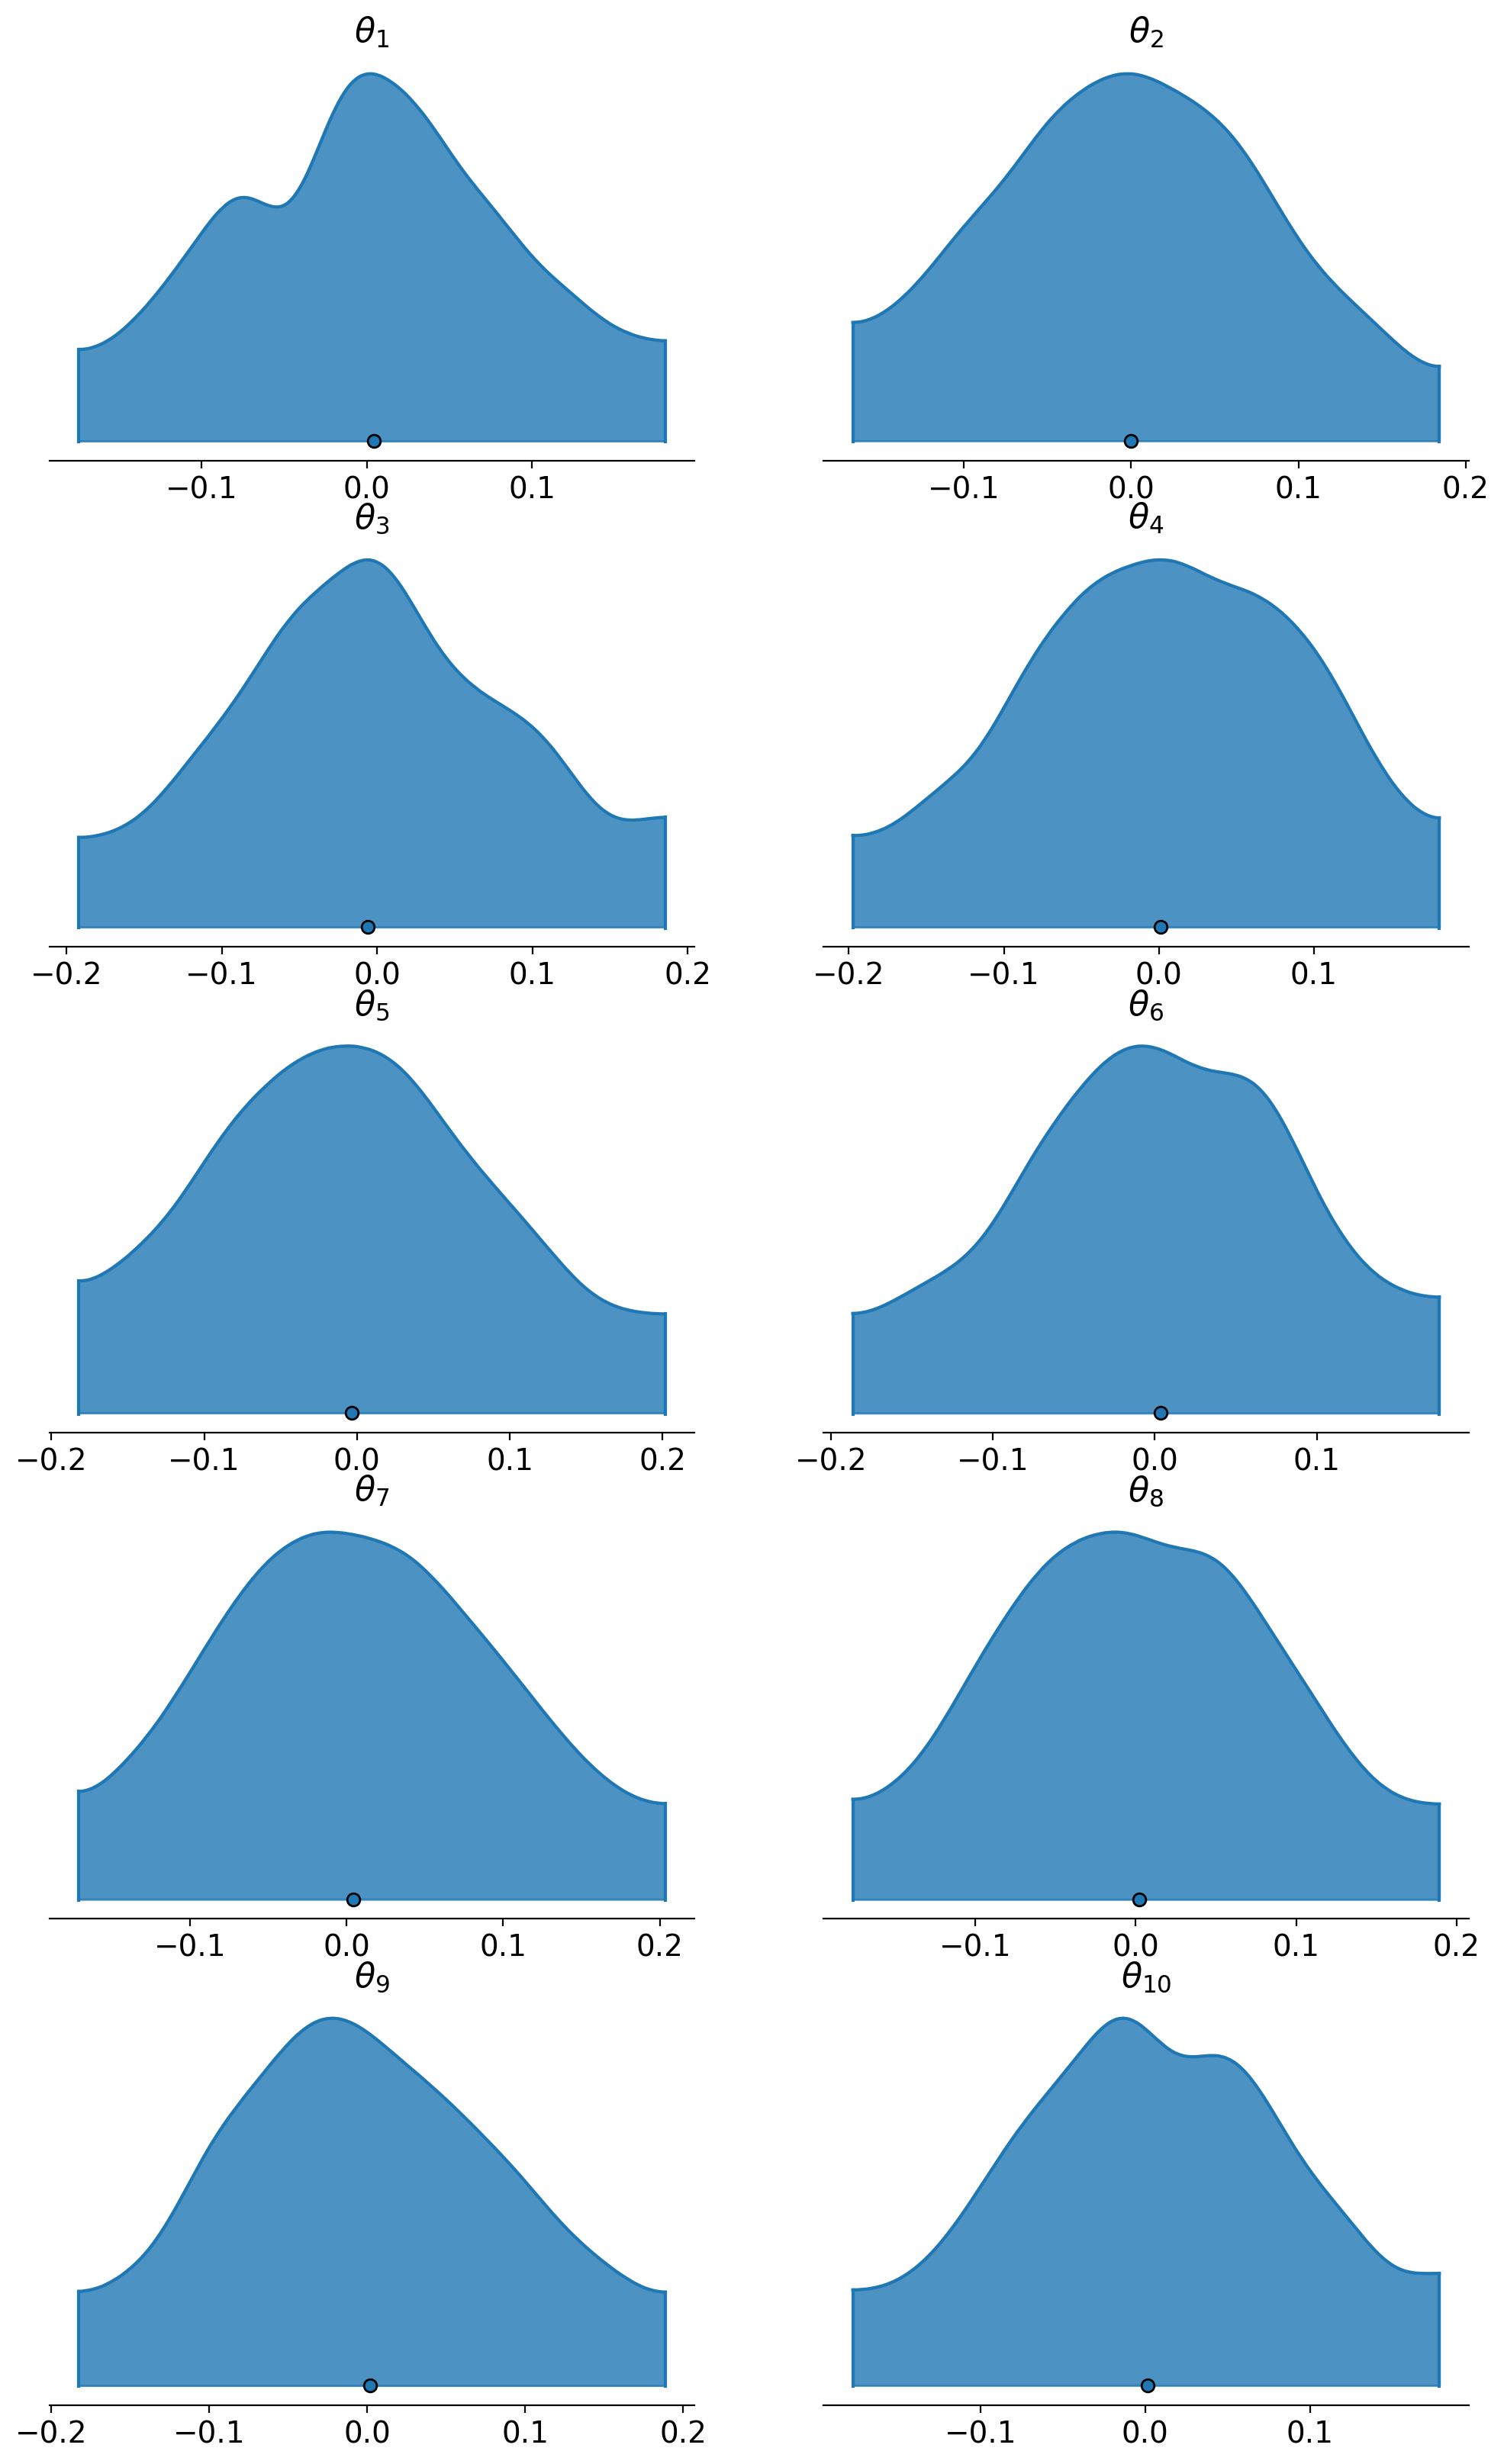

array([[<Axes: title={'center': '$\\theta_{1}$'}>,
        <Axes: title={'center': '$\\theta_{2}$'}>],
       [<Axes: title={'center': '$\\theta_{3}$'}>,
        <Axes: title={'center': '$\\theta_{4}$'}>],
       [<Axes: title={'center': '$\\theta_{5}$'}>,
        <Axes: title={'center': '$\\theta_{6}$'}>],
       [<Axes: title={'center': '$\\theta_{7}$'}>,
        <Axes: title={'center': '$\\theta_{8}$'}>],
       [<Axes: title={'center': '$\\theta_{9}$'}>,
        <Axes: title={'center': '$\\theta_{10}$'}>]], dtype=object)

In [7]:
theta_labels = get_labels_for_var("\\theta", ndim)
theta_dataset = tensor_to_dataset(theta_labels, theta)

plot_kwargs = dict(shade=0.8, grid=(5, 2), figsize=(12, 20), show=True)
az.plot_density(theta_dataset, var_names=theta_labels, **plot_kwargs)

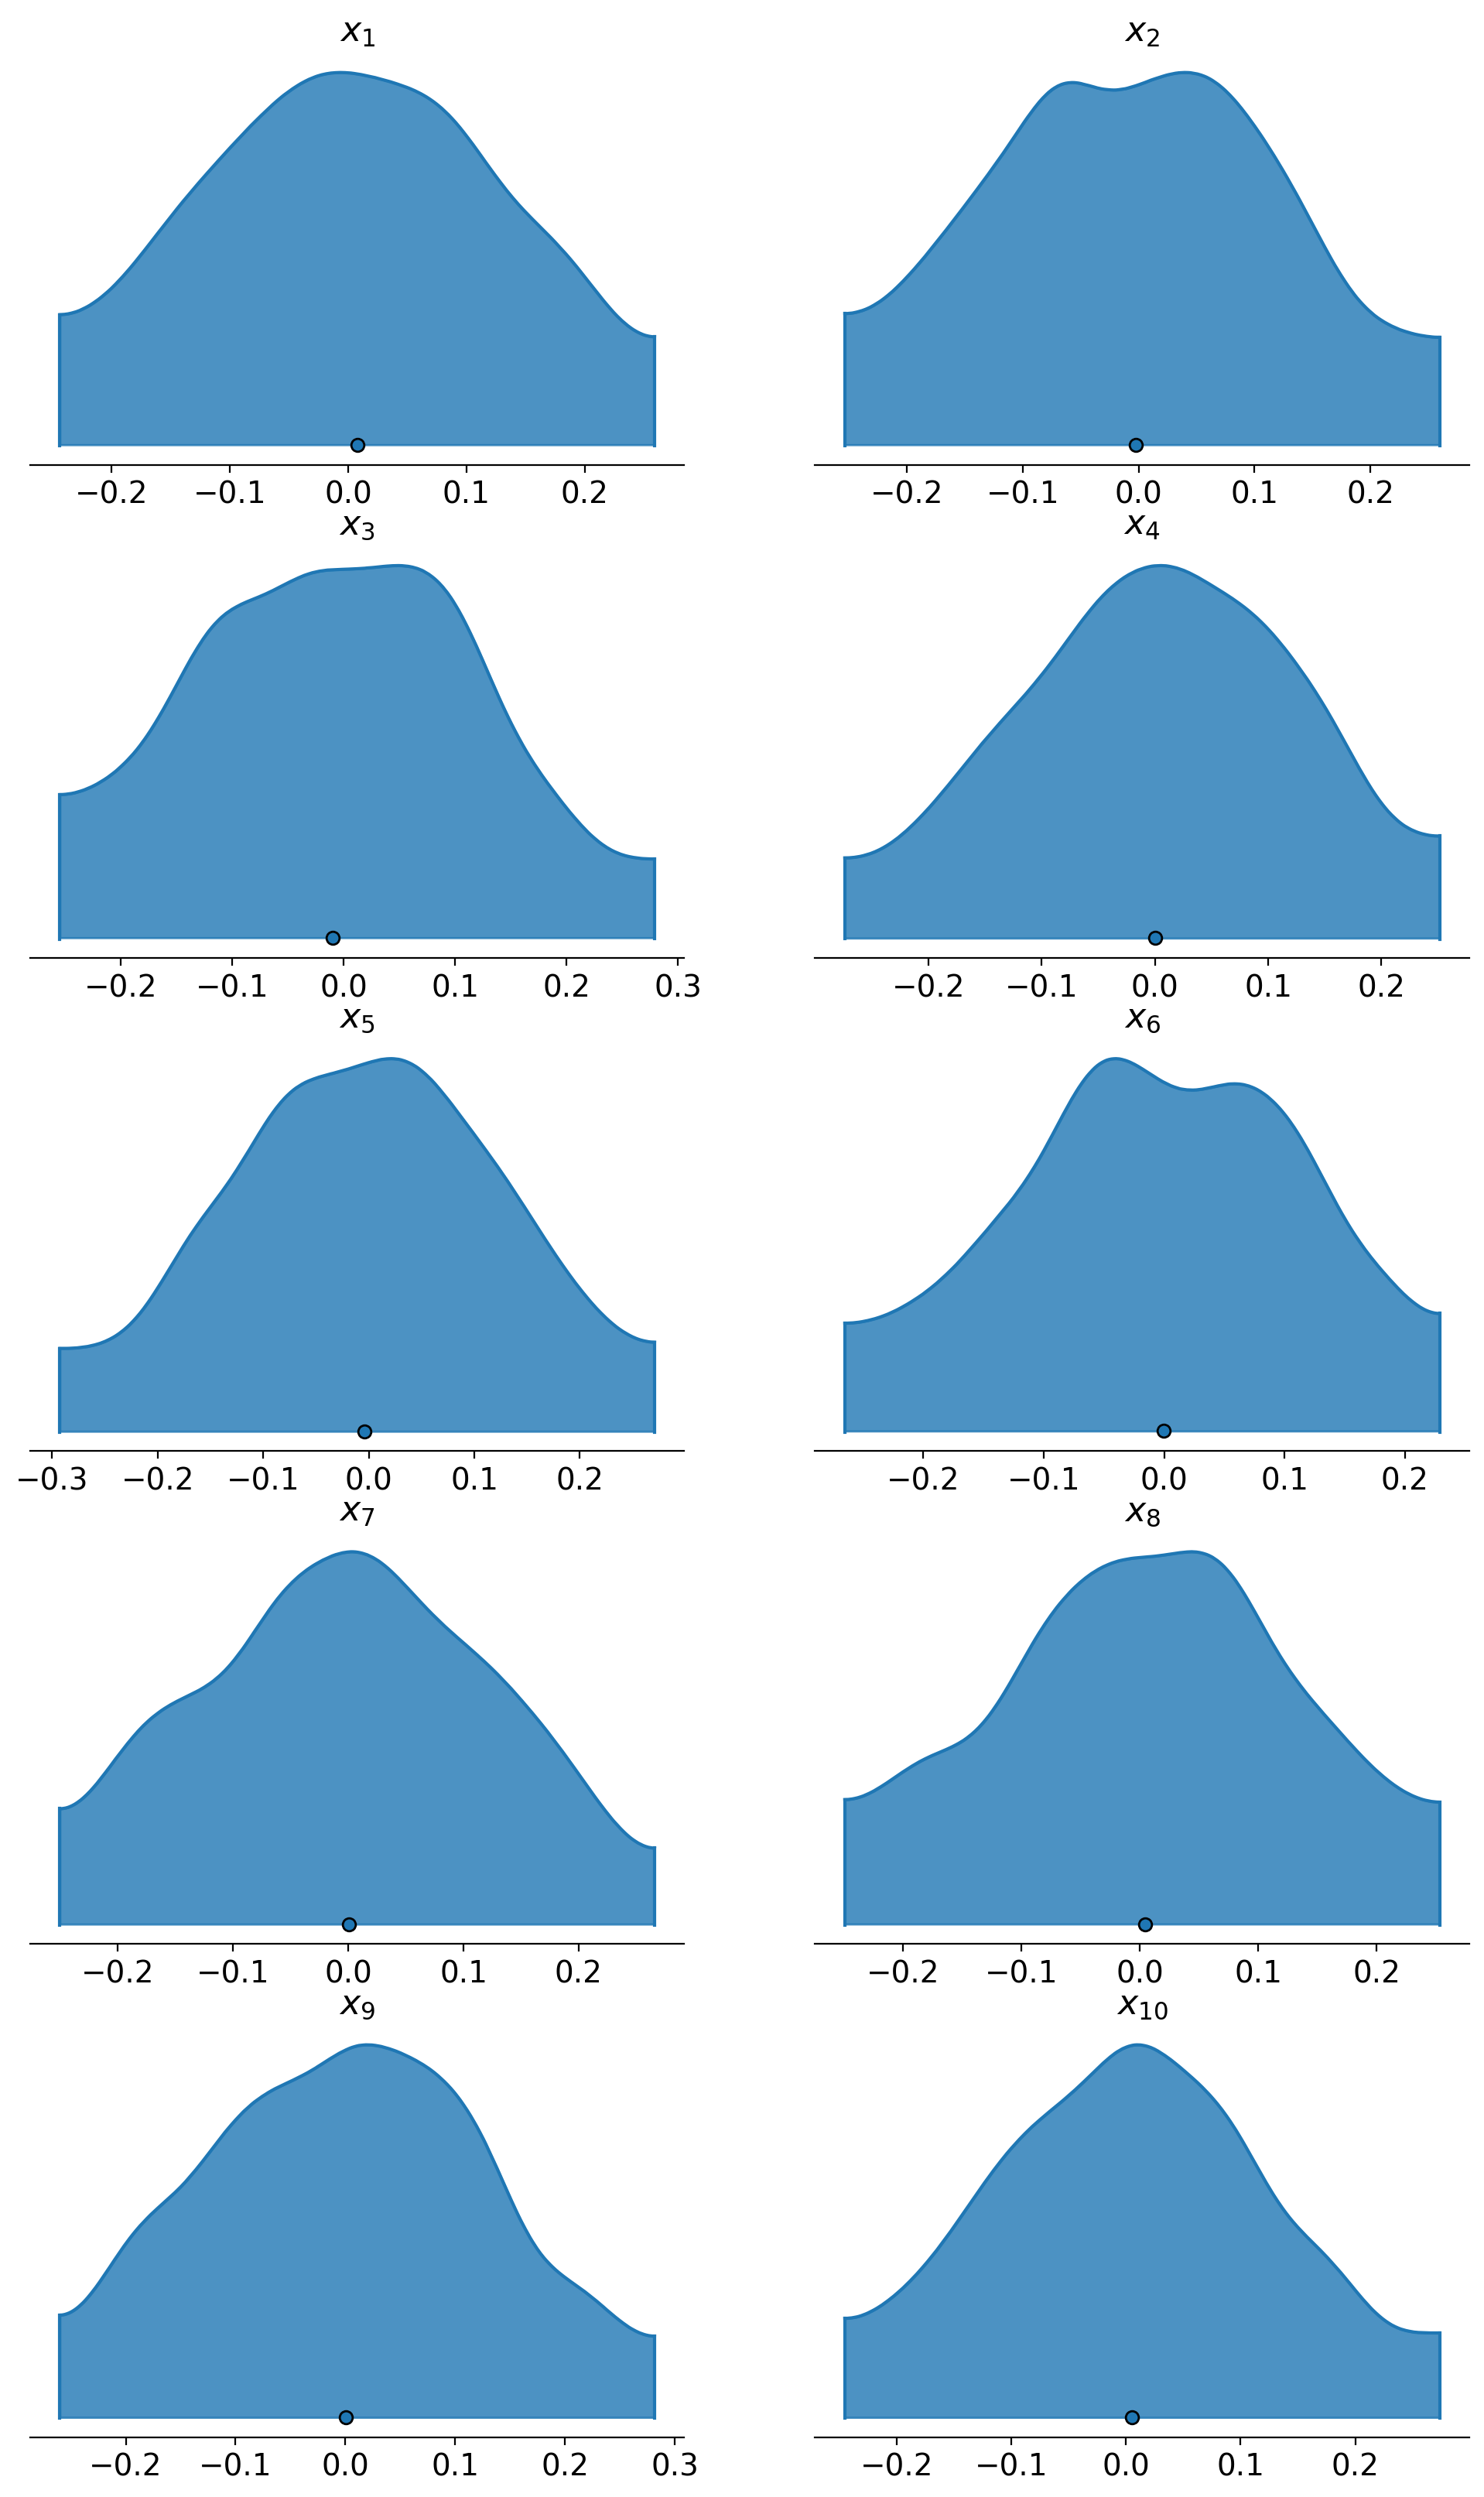

array([[<Axes: title={'center': '$x_{1}$'}>,
        <Axes: title={'center': '$x_{2}$'}>],
       [<Axes: title={'center': '$x_{3}$'}>,
        <Axes: title={'center': '$x_{4}$'}>],
       [<Axes: title={'center': '$x_{5}$'}>,
        <Axes: title={'center': '$x_{6}$'}>],
       [<Axes: title={'center': '$x_{7}$'}>,
        <Axes: title={'center': '$x_{8}$'}>],
       [<Axes: title={'center': '$x_{9}$'}>,
        <Axes: title={'center': '$x_{10}$'}>]], dtype=object)

In [8]:
x_labels = get_labels_for_var("x", ndim)
x_dataset = tensor_to_dataset(x_labels, x)

az.plot_density(x_dataset, var_names=x_labels, **plot_kwargs)

The output of prior + simulator is the set 

$$\{(\bm{\theta}_i, \bm{x}_i)\},$$

for $i=1, \ldots, N_{sim}$. This will be the data used for the training and validation of the neural network.

## NPE

$$
\renewcommand{\params}{\bm{\theta}}
\renewcommand{\data}{\bm{x}}
\renewcommand{\prior}{p(\bm{\theta})}
\renewcommand{\like}{p(\bm{x} | \bm{\theta})}
\renewcommand{\posterior}{p(\bm{\theta} | \bm{x})}
\renewcommand{\evidence}{p(\bm{x})}
$$

Neural Posterior Estimation (NPE) consists of training a neural density estimator with a simulated dataset to directly approximate the posterior~\citep{papamakarios_fast_2016, lueckmann_flexible_2017}. One advantage of this approach is that one can directly sample from the amortized approximation of the posterior, without having to perform extra MCMC steps.

The estimator is trained to minimize the loss function

$$
    \mathcal{L} = \mathbb{E}_{\bm{\theta} \sim \prior} \mathbb{E}_{\bm{x} \sim \like} \left[-\log q_{\bm{\phi}} (\prior | \data) \right],
$$

which attains a minimum at $q_{\bm{\phi}} (\bm{\theta} | \bm{x}) = \posterior$. Indeed, by writing it explicity,

$$
    \mathcal{L} = -\iint d\data d\params \prior \like \log q_{\bm{\phi}}(\params | \data),
$$

one can apply Bayes' theorem and commute the integrals to write
$$
\begin{split}
    \mathcal{L} &= -\int d\data \evidence \int d\params \posterior \log q_{\bm{\phi}}(\params | \data) \\
    &=D_{KL}\left[q_{\bm{\phi}}(\params | \data) \parallel \posterior \right] + \rm{const},
\end{split}
$$
where the first term is recognized to be the conditional relative entropy between $q_{\bm{\phi}}(\params | \data)$ and the true posterior distribution $\posterior$, which is zero if and only if the two measures are equal almost everywhere, and positive otherwise. The additional constant term does not depend on  $q_{\bm{\phi}}$ and equals

$$
    \mathbb{E}_{\bm{\theta} \sim \prior} \mathbb{E}_{\bm{x} \sim \like} \left[-\log \posterior \right].
$$

More generally, if $\params$ is sampled from a proposal distribution $\tilde{p}(\params)$, then 

$$
    \underset{q_{\bm{\phi}}}{\rm{argmin}}  \, \mathcal{L} (\bm{\theta} | \bm{x}) =  \frac{\tilde{p}(\params)}{\prior}\posterior.
$$

A common implementation of the estimator $q_{\bm{\phi}}(\params | \data)$ is with a normalizing flow

In [9]:
from sbi.inference import SNPE

inference = SNPE(prior=prior)
inference.append_simulations(theta, x)

Training the neural network:

In [10]:
density_estimator = inference.train()

 Neural network successfully converged after 63 epochs.

The output of the training is the density estimator, which we can use to build the posterior:

In [11]:
posterior = inference.build_posterior(density_estimator=density_estimator)

In [12]:
num_samples = 10000
fiducial_theta, fiducial_x = simulate_for_sbi(simulator, prior, 1)
samples = posterior.sample((num_samples,), x=fiducial_x)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
# plt.rcParams['plot.max_subplots'] = ndim ** 2 + 1
dataset = tensor_to_dataset(theta_labels, samples)
reference_values = dict(zip(theta_labels, fiducial_theta.squeeze()))
with az.rc_context({"plot.max_subplots": ndim**2 + 1}):
    _ = az.plot_pair(
        dataset,
        var_names=theta_labels,
        marginals=True,
        reference_values=reference_values,
        reference_values_kwargs={"ls": "dotted", "lw": 20, "color": "red"},
    )